# Topic modelling

This notebook uses the 2kIMPACT dataset to perform an analysis of the impact of OCR quality on topic modelling with LDA. We use a variety of methods and find that:
* Results are very stable between the ground truth and OCRed version of this dataset
* This likely is the case because we use an aggressive pre-processing pipeline which limits the impact of noisy OCR
* Nevertheless, we caution that document-topic distributions, while stable and comparable between the two versions, can still diverge significantly if used to construct bins of documents (hard clustering)

In [1]:
from glob import glob
import jellyfish
import numpy as np
import os, codecs, re
from tqdm import tqdm
import pandas as pd
from bs4 import BeautifulSoup

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random
from tqdm import tqdm
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, gensim, sklearn, spacy
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### For this analysis we focus on the 2kIMPACT dataset

In [5]:
df = pd.read_csv("data_frames/full_df_2kIMPACT.csv", compression="gzip")

In [7]:
df.head(1)

,filename,text_ground,text_ocr,word_level_confidence_ocr,text_reocr,word_level_confidence_reocr,word_level_average_confidence_ocr,word_level_average_confidence_reocr
0,DDD_010197037_001.jp2,"['No.', '9922.', 'Tweede', 'Blad.', 'Vrijdag',...","['JSo.', '9822', 'xTweede', 'Blad.', 'Vrijdag'...","[0.27, 0.27, 0.29, 0.95, 0.98, 1.0, 0.97, 0.67...","['ISO.', '9922', '-Tweede', 'Blad.', 'ss*', 'V...","[0.94, 0.23, 0.97, 0.95, 0.16, 0.97, 0.96, 0.9...",0.719354,0.718463


In [8]:
#from tabulate import tabulate

In [9]:
#print(tabulate(df.head(2), tablefmt="pipe", headers="keys"))

##### Taking a look at OCR quality and document length

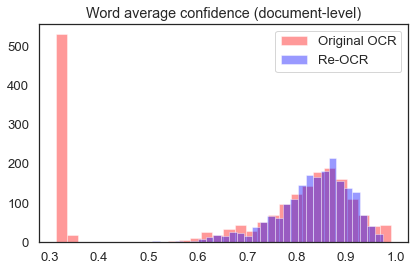

In [116]:
sns.distplot(df["word_level_average_confidence_ocr"].values, label="Original OCR", kde=False, color="red", bins=30)
sns.distplot(df["word_level_average_confidence_reocr"].values, label="Re-OCR", kde=False, color="blue", bins=30)
plt.title("Word average confidence (document-level)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/tm_OCR_quality.png")

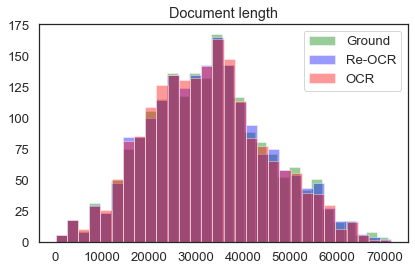

In [117]:
sns.distplot([len(x) for x in df["text_ground"].values], label="Ground", kde=False, color="green", bins=30)
sns.distplot([len(x) for x in df["text_reocr"].values], label="Re-OCR", kde=False, color="blue", bins=30)
sns.distplot([len(x) for x in df["text_ocr"].values], label="OCR", kde=False, color="red", bins=30)
plt.title("Document length")
plt.legend()
plt.tight_layout()
plt.savefig("figures/tm_doc_len.png")

### Setup and pre-processing

In [12]:
!python -m spacy download nl

     |████████████████████████████████| 36.7 MB 5.9 MB/s eta 0:00:01

    Linking successful
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/nl_core_news_sm -->
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/spacy/data/nl

    You can now load the model via spacy.load('nl')



##### We focus on the original OCR (lower quality)

In [68]:
# focus on a sample of documents (mainly yo speed up experiments)
sample_size = 1000

sample_ground = df["text_ground"].sample(n=sample_size, random_state=seed)
sample_ocr = df["text_ocr"].sample(n=sample_size, random_state=seed)

In [69]:
print(len(sample_ground))

1000


In [70]:
sample_ground[:2]

1414    ['Woensdag', '28', 'juli', '1965', '48e', 'Jaa...
1750    ['Derde', 'waarschuwing', 'De', 'verhoging', '...
Name: text_ground, dtype: object

In [71]:
sample_ocr[:2]

1414    ['Woensdag', '28', 'juli', '1965', '48e', 'Jaa...
1750    ['Derde', 'waarschuwing', 'Tye', 'verhoging', ...
Name: text_ocr, dtype: object

##### Check whether the sample resembles the full dataset in terms of document length

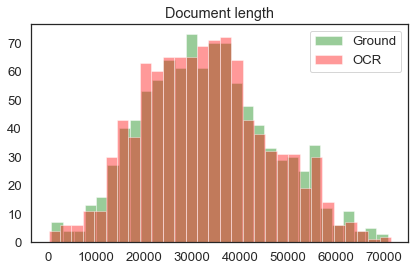

In [72]:
sns.distplot([len(x) for x in sample_ground], label="Ground", kde=False, color="green", bins=30)
sns.distplot([len(x) for x in sample_ocr], label="OCR", kde=False, color="red", bins=30)
plt.title("Document length")
plt.legend()
plt.tight_layout()

In [73]:
# trim the number of characters in use for each document

LIMIT = 30000

sample_ground = [x[:LIMIT] for x in sample_ground]
sample_ocr = [x[:LIMIT] for x in sample_ocr]

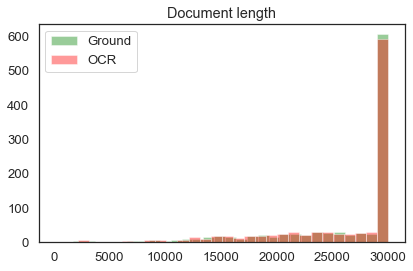

In [74]:
sns.distplot([len(x) for x in sample_ground], label="Ground", kde=False, color="green", bins=30)
sns.distplot([len(x) for x in sample_ocr], label="OCR", kde=False, color="red", bins=30)
plt.title("Document length")
plt.legend()
plt.tight_layout()

### Pre-processing

We apply a canonical pre-processing pipeline before topic modelling, including the following steps:

* Remove stop-words
* Lemmatize
* Lowercase
* Remove tokens shorter than 3 characters
* Add frequent bigrams

In [75]:
nlp = spacy.load('nl')
STOPWORDS = spacy.lang.nl.stop_words.STOP_WORDS
STOPWORDS.add("eene")

In [80]:
%%time

processed_docs = list()
for doc in nlp.pipe(sample_ground, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    #ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token.lower() for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than one word.
    #doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)

CPU times: user 1h 6s, sys: 15min 33s, total: 1h 15min 39s
Wall time: 1h 26min 6s


In [81]:
docs = processed_docs
del processed_docs

# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear 20 times or more). A better approach would be to use a chi_sq test.
bigram = Phrases(docs, min_count=25)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [82]:
# You will need to run the same pipeline twice, for ground truth and OCR documents. Comment/uncomment this part each time:
docs_ground = docs
#docs_ocr = docs

In [83]:
# save
import pickle

with open('folder_topic_modelling/docs_ground.pkl', 'wb') as handle:
    pickle.dump(docs_ground, handle)
with open('folder_topic_modelling/docs_ocr.pkl', 'wb') as handle:
    pickle.dump(docs_ocr, handle)

#### Start from the pre-processed corpus

In [84]:
# load corpora
import pickle

docs_ground = list()
docs_ocr = list()

with open('folder_topic_modelling/docs_ground.pkl', 'rb') as handle:
    docs_ground = pickle.load(handle)
with open('folder_topic_modelling/docs_ocr.pkl', 'rb') as handle:
    docs_ocr = pickle.load(handle)

In [85]:
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5

In [86]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary_ground = Dictionary(docs_ground)
dictionary_ground.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus_ground = [dictionary_ground.doc2bow(doc) for doc in docs_ground]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary_ground))
print('Number of docs: %d' % len(corpus_ground))

Number of unique tokens: 26166
Number of docs: 1000


In [87]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary_ocr = Dictionary(docs_ocr)
dictionary_ocr.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus_ocr = [dictionary_ocr.doc2bow(doc) for doc in docs_ocr]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary_ocr))
print('Number of docs: %d' % len(corpus_ocr))

Number of unique tokens: 25680
Number of docs: 1000


## LDA

In [88]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 15,'passes': 5, 'random_state': seed}
model_ground = LdaModel(corpus=corpus_ground, num_topics=params['num_topics'], id2word=dictionary_ground, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 2min 10s, sys: 881 ms, total: 2min 10s
Wall time: 33.8 s


In [89]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 15,'passes': 5, 'random_state': seed}
model_ocr = LdaModel(corpus=corpus_ocr, num_topics=params['num_topics'], id2word=dictionary_ocr, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 1min 57s, sys: 386 ms, total: 1min 58s
Wall time: 30 s


In [90]:
model_ground.show_topics(num_words=5)

[(4,
  '0.007*"regering" + 0.003*"grote" + 0.003*"amerikaanse" + 0.003*"president" + 0.003*"tussen"'),
 (9, '0.008*"les" + 0.005*"que" + 0.004*"dans" + 0.003*"par" + 0.002*"qui"'),
 (2, '0.003*"nws" + 0.002*"zyn" + 0.002*"gram" + 0.002*"grote" + 0.002*"the"'),
 (12,
  '0.003*"grote" + 0.002*"regering" + 0.002*"tussen" + 0.002*"mensen" + 0.002*"nederlandse"'),
 (11,
  '0.004*"den_heer" + 0.003*"gemeente" + 0.003*"vergadering" + 0.002*"voorzitter" + 0.002*"prijs"'),
 (1,
  '0.002*"den_heer" + 0.002*"tusschen" + 0.002*"cent" + 0.002*"staten" + 0.002*"frankrijk"'),
 (13,
  '0.003*"duitsche" + 0.002*"regeering" + 0.002*"reuter" + 0.002*"troepen" + 0.002*"kamer"'),
 (5,
  '0.010*"zyn" + 0.004*"nieuws" + 0.004*"zig" + 0.003*"the" + 0.003*"zyne"'),
 (8,
  '0.002*"den_heer" + 0.002*"gemeente" + 0.002*"besluit" + 0.002*"april" + 0.002*"juli"'),
 (7,
  '0.002*"dito" + 0.002*"school" + 0.002*"nov" + 0.002*"september" + 0.002*"vergadering"')]

In [91]:
model_ocr.show_topics(num_words=5)

[(7,
  '0.003*"gram" + 0.002*"den_heer" + 0.001*"berichten" + 0.001*"maart" + 0.001*"melk"'),
 (13,
  '0.003*"troepen" + 0.003*"duitsche" + 0.002*"maart" + 0.002*"reuter" + 0.002*"oorlog"'),
 (1,
  '0.003*"dito" + 0.002*"zegt" + 0.002*"grote" + 0.001*"regering" + 0.001*"kerk"'),
 (3,
  '0.002*"gisteren" + 0.002*"grote" + 0.002*"rotterdam" + 0.002*"tussen" + 0.002*"regering"'),
 (4,
  '0.002*"den_heer" + 0.002*"kamer" + 0.002*"bet" + 0.002*"heeren" + 0.002*"vergadering"'),
 (14,
  '0.003*"bet" + 0.003*"zyn" + 0.002*"uyt" + 0.002*"politie" + 0.001*"raad"'),
 (9,
  '0.004*"regering" + 0.003*"grote" + 0.002*"amerikaanse" + 0.002*"tussen" + 0.002*"aldus"'),
 (11,
  '0.005*"duitsche" + 0.003*"fransche" + 0.003*"regeering" + 0.003*"oorlog" + 0.002*"duitschland"'),
 (12,
  '0.006*"sept" + 0.003*"aug" + 0.002*"juli" + 0.002*"den_heer" + 0.002*"alhier"'),
 (8,
  '0.005*"the" + 0.004*"nieuws" + 0.004*"journaal" + 0.004*"nos" + 0.003*"nws"')]

### Evaluation

#### Intrinsic

Intrinsic evaluation uses internal measurements of the quality of topics. See [here](http://qpleple.com/topic-coherence-to-evaluate-topic-models) for more info.

In [92]:
# Perplexity ground truth
print('\nPerplexity: ', model_ground.log_perplexity(corpus_ground))  # a measure of how good the model is. The lower the better.

# Coherence score
coherence_model_lda = CoherenceModel(model=model_ground, texts=docs_ground, dictionary=dictionary_ground, coherence='c_uci')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

coherence_model_lda = CoherenceModel(model=model_ground, texts=docs_ground, dictionary=dictionary_ground, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.389315250655148

Coherence Score:  -2.2255753211989995

Coherence Score:  0.4094431142335144


In [93]:
# Perplexity OCR
print('\nPerplexity: ', model_ocr.log_perplexity(corpus_ocr))  # a measure of how good the model is. The lower the better.

# Coherence score
coherence_model_lda = CoherenceModel(model=model_ocr, texts=docs_ground, dictionary=dictionary_ocr, coherence='c_uci')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

coherence_model_lda = CoherenceModel(model=model_ocr, texts=docs_ocr, dictionary=dictionary_ocr, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.404431513546122

Coherence Score:  -2.2070254134095317

Coherence Score:  0.39579268371304915


#### Extrinsic

Extrinsic evaluation uses comparisons with results from ground truth. 

##### Match of topics

We match every topic in the OCR model with a topic in the human model (by best matching), and assess the overall distance between the two using the weighted total distance over a set of N top words (from the human model to the ocr model). The higher this value, the closest two topics are.

Note that to find a matching, we create a weighted network and find the maximal bipartite matching using NetworkX.

Afterwards, we can measure the distance of the best match, e.g., using the KL divergence (over the same set of words).

In [94]:
import networkx as nx

G = nx.Graph()

top_n = 500 # how many words to use

# add bipartite nodes
G.add_nodes_from(['h_'+str(t_h[0]) for t_h in model_ground.show_topics(num_topics = -1, formatted=False, num_words=1)], bipartite=0)
G.add_nodes_from(['o_'+str(t_o[0]) for t_o in model_ocr.show_topics(num_topics = -1, formatted=False, num_words=1)], bipartite=1)

# add weighted edges
for t_h in model_ground.show_topics(num_topics = -1, formatted=False, num_words=top_n):
    for t_o in model_ocr.show_topics(num_topics = -1, formatted=False, num_words=top_n):
        # note that the higher the weight, the shorter the distance between the two distributions, so we do 1-weight to then do minimal matching
        words_of_h = [x[0] for x in t_h[1]]
        words_of_o = [x[0] for x in t_o[1]]
        weights_of_o = {x[0]:x[1] for x in t_o[1]}
        words_in_common = list(set(words_of_h).intersection(set(words_of_o)))
        # sum the weighted joint probability of every shared word in the two models
        avg_weight = 1 - sum([x[1]*weights_of_o[x[0]] for x in t_h[1] if x[0] in words_in_common])
        G.add_edge('h_'+str(t_h[0]),'o_'+str(t_o[0]),weight=avg_weight)
        G.add_edge('o_'+str(t_o[0]),'h_'+str(t_h[0]),weight=avg_weight)

In [95]:
len(G.edges()) # square of number of topics

225

In [96]:
nx.is_bipartite(G)

True

In [97]:
nx.is_connected(G)

True

In [98]:
bipartite_solution = nx.bipartite.matching.minimum_weight_full_matching(G)

In [99]:
from scipy.stats import entropy
from collections import defaultdict

# analyse matches

distances = list()
n_words_in_common = list()
matches = defaultdict(int)

for match_h,match_o in bipartite_solution.items():
    if match_h.startswith('o'): # to avoid repeating the matches (complete graph!)
        break
    matches[int(match_h.split("_")[1])] = int(match_o.split("_")[1])
    m_h = model_ground.show_topic(int(match_h.split("_")[1]), topn=top_n)
    m_o = model_ocr.show_topic(int(match_o.split("_")[1]), topn=top_n)
    weights_of_o = {x[0]:x[1] for x in m_o}
    words_of_h = [x[0] for x in m_h]
    words_of_o = [x[0] for x in m_o]
    words_in_common = list(set(words_of_h).intersection(set(words_of_o)))
    n_words_in_common.append(len(words_in_common)/top_n)
    dist_h = list()
    dist_o = list()
    for w in m_h:
        if w[0] in words_in_common:
            dist_h.append(w[1])
            dist_o.append(weights_of_o[w[0]])
    print("ground",match_h,model_ground.show_topic(int(match_h.split("_")[1])))
    print("OCR",match_o,model_ocr.show_topic(int(match_o.split("_")[1])))
    # normalize
    dist_h = dist_h/sum(dist_h)
    dist_o = dist_o/sum(dist_o)
    dist = entropy(dist_h,dist_o)
    distances.append(dist)
    print("KL divergence", dist)
    print("Words in common", len(words_in_common))
    print('=======')

ground h_10 [('regeering', 0.0038295134), ('duitsche', 0.0031397934), ('maart', 0.0017407852), ('fransche', 0.001623009), ('engelsche', 0.0015461006), ('duitschland', 0.0014947052), ('zooals', 0.0014853105), ('tusschen', 0.0014602217), ('japan', 0.0014393915), ('zout', 0.0013657867)]
OCR o_13 [('troepen', 0.0029701835), ('duitsche', 0.002949589), ('maart', 0.0023937852), ('reuter', 0.0023370532), ('oorlog', 0.0021438692), ('londen', 0.0019526466), ('regeering', 0.0018999613), ('tusschen', 0.0018224432), ('parijs', 0.001745937), ('bericht', 0.0016383075)]
KL divergence 0.0787657
Words in common 289
ground h_5 [('zyn', 0.00978431), ('nieuws', 0.003625967), ('zig', 0.003508388), ('the', 0.002963446), ('zyne', 0.002848769), ('hof', 0.0022281772), ('nos', 0.0021196788), ('dezelve', 0.0020929757), ('afl', 0.002081613), ('word', 0.0020116111)]
OCR o_14 [('bet', 0.0032391043), ('zyn', 0.0027920655), ('uyt', 0.0020045894), ('politie', 0.0017369549), ('raad', 0.0014907368), ('alhier', 0.00145995

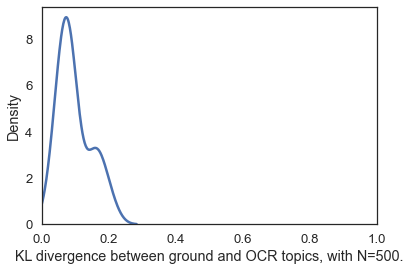

In [118]:
sns.distplot(distances, hist=False)
plt.xlim((0,1))
plt.xlabel("KL divergence between ground and OCR topics, with N=%d."%top_n)
plt.savefig("figures/tm_KL.png")

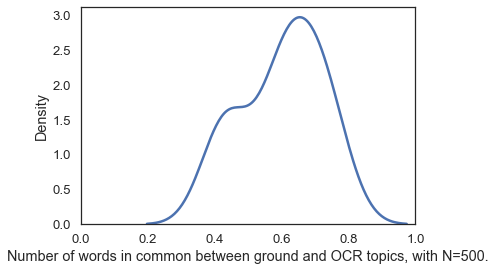

In [119]:
sns.distplot(n_words_in_common, hist=False)
plt.xlim((0,1))
plt.xlabel("Number of words in common between ground and OCR topics, with N=%d."%top_n)
plt.savefig("figures/tm_words_in_common.png")

#### Entropy

Does the entropy (a measure of variety) of the topic distribution per document vary between the ground truth and the OCR version of the dataset?

In [120]:
# this is how to access a document's topic distrbution

sorted(model_ground[corpus_ground[1]],key=lambda x:x[1],reverse=True)

[(6, 0.5723313), (12, 0.22523777), (4, 0.15245546), (2, 0.04940966)]

In [121]:
# entropy

from scipy.stats import entropy

In [122]:
entropies_ground = list()
max_cluster_ground = list()
for d in corpus_ground:
    entropies_ground.append(entropy([x[1] for x in model_ground[d]]))
    max_cluster_ground.append(sorted(model_ground[d],key=lambda x:x[1],reverse=True)[0][0])
    
entropies_ocr = list()
max_cluster_ocr = list()
for d in corpus_ocr:
    entropies_ocr.append(entropy([x[1] for x in model_ocr[d]]))
    max_cluster_ocr.append(sorted(model_ocr[d],key=lambda x:x[1],reverse=True)[0][0])

KstestResult(statistic=0.132, pvalue=5.194801845515002e-08)

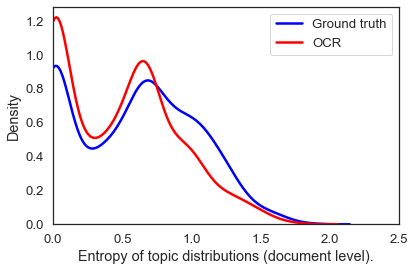

In [129]:
import seaborn as sns

sns.distplot(entropies_ground, hist=False, rug=False, label="Ground truth", color="blue")
sns.distplot(entropies_ocr, hist=False, rug=False, label="OCR", color="red")

plt.xlabel("Entropy of topic distributions (document level).")
plt.xlim((0,2.5))
plt.legend()
plt.tight_layout()
plt.savefig("figures/tm_entropy_documents.png")

from scipy.stats import ks_2samp, ttest_ind
ks_2samp(entropies_ground, entropies_ocr)

In [126]:
# Let's do the same for the topic distribution itself, considering the top N words

from collections import defaultdict

top_n_l = [500,1000,2000,5000]
entropies_ground_topics = defaultdict(list)
entropies_ocr_topics = defaultdict(list)

for tn in top_n_l:
    for t in model_ground.show_topics(num_topics=-1, formatted=False, num_words=tn):
        entropies_ground_topics[tn].append(entropy([x[1] for x in t[1]]))

    for t in model_ocr.show_topics(num_topics=-1, formatted=False, num_words=tn):
        entropies_ocr_topics[tn].append(entropy([x[1] for x in t[1]]))

Number of top n words: 500
KstestResult(statistic=0.3333333333333333, pvalue=0.3855465198257425)
Ttest_indResult(statistic=-1.4846015712630627, pvalue=0.14882117722204002)
Number of top n words: 1000
KstestResult(statistic=0.3333333333333333, pvalue=0.3855465198257425)
Ttest_indResult(statistic=-1.442463495096302, pvalue=0.16026541299012315)
Number of top n words: 2000
KstestResult(statistic=0.3333333333333333, pvalue=0.3855465198257425)
Ttest_indResult(statistic=-1.351076548952578, pvalue=0.18748808330450323)
Number of top n words: 5000
KstestResult(statistic=0.3333333333333333, pvalue=0.3855465198257425)
Ttest_indResult(statistic=-1.5161352599277695, pvalue=0.1406946700582477)


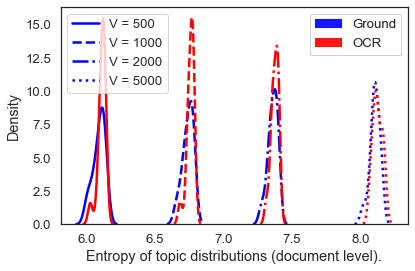

In [128]:
import matplotlib.patches as mpatches

line_styles = ['-', '--', '-.', ':']

for n,tn in enumerate(top_n_l):
    print("Number of top n words:",tn)
    sns.distplot(entropies_ground_topics[tn], hist=False, rug=False, label="V = %d"%tn, color="blue", kde_kws={'linestyle':line_styles[n]})
    sns.distplot(entropies_ocr_topics[tn], hist=False, rug=False, color="red", kde_kws={'linestyle':line_styles[n]})
    print(ks_2samp(entropies_ground_topics[tn], entropies_ocr_topics[tn]))
    print(ttest_ind(entropies_ground_topics[tn], entropies_ocr_topics[tn]))
    print("============")

legend1 = plt.legend(loc="upper left")
blue_patch = mpatches.Patch(color='blue', label='Ground', linestyle="-", linewidth=0.1, alpha=0.9)
red_patch = mpatches.Patch(color='red', label='OCR', linestyle="-", linewidth=0.1, alpha=0.9)
legend2 = plt.legend(handles=[blue_patch,red_patch], loc="upper right")
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.xlabel("Entropy of topic distributions (document level).")
plt.tight_layout()
plt.savefig("figures/tm_entropy_topic_distr.png")

#### Clustering by top topic

Here we verify whether the topic allocation for a document is consistent between ground truth and OCR versions. To do so, we assume a document belongs to the highest probability topic only, and we use the topic to topic mapping established above. We then verify what is the proportion of documents with consistent assignments over the two versions of the data.

Results indicate that such consistency is relatively low, but it varies widely across topics.

In [130]:
matches_per_cluster = defaultdict(int)
documents_per_cluster = defaultdict(int)

for h,o in zip(max_cluster_ground,max_cluster_ocr):
    documents_per_cluster[h] += 1
    if o == matches[h]:
        matches_per_cluster[h] += 1

In [131]:
matches_per_cluster

defaultdict(int,
            {13: 23,
             11: 32,
             4: 31,
             12: 51,
             2: 26,
             7: 10,
             3: 2,
             0: 1,
             8: 10,
             10: 1,
             5: 3,
             9: 4,
             1: 2,
             6: 2,
             14: 1})

In [132]:
documents_per_cluster

defaultdict(int,
            {2: 65,
             6: 276,
             8: 124,
             13: 140,
             0: 41,
             12: 87,
             11: 78,
             7: 21,
             4: 43,
             3: 60,
             14: 9,
             9: 13,
             5: 22,
             1: 11,
             10: 10})

In [133]:
clusters_proportions = [v/documents_per_cluster[k] for k,v in matches_per_cluster.items()]

clusters_proportions

[0.16428571428571428,
 0.41025641025641024,
 0.7209302325581395,
 0.5862068965517241,
 0.4,
 0.47619047619047616,
 0.03333333333333333,
 0.024390243902439025,
 0.08064516129032258,
 0.1,
 0.13636363636363635,
 0.3076923076923077,
 0.18181818181818182,
 0.007246376811594203,
 0.1111111111111111]

In [134]:
np.average(clusters_proportions)

0.24936467214435934

In [135]:
np.median(clusters_proportions)

0.16428571428571428

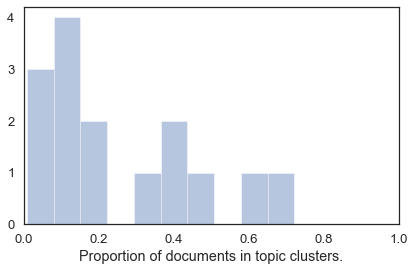

In [141]:
sns.distplot(clusters_proportions, norm_hist=False, bins=10, kde=False)
plt.xlabel("Proportion of documents in topic clusters.")
plt.xlim((0,1))
plt.tight_layout()

#### Manual inspection of some documents for comparison

From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

Find the most discriminative document per topic. For topic-topic matching, see above.

In [142]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords_ground = format_topics_sentences(ldamodel=model_ground, corpus=corpus_ground, texts=docs_ground)
df_topic_sents_keywords_ocr = format_topics_sentences(ldamodel=model_ocr, corpus=corpus_ocr, texts=docs_ocr)

# Format
df_dominant_topic_ground = df_topic_sents_keywords_ground.reset_index()
df_dominant_topic_ground.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_ocr = df_topic_sents_keywords_ocr.reset_index()
df_dominant_topic_ocr.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [143]:
# Show
df_dominant_topic_ground.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6733,"nws, zyn, gram, grote, the, nieuws, journaal, ...","[woensdag, juli, jaargang, abonnees, limburgs,..."
1,1,6.0,0.5724,"tusschen, vrouw, gij, zegt, regeering, zijne, ...","[derde, waarschuwing, verhoging, rente, nederl..."
2,2,8.0,0.9714,"den_heer, gemeente, besluit, april, juli, beno...","[onderscheiden, gemakkelijk, volgen, biljetten..."
3,3,13.0,0.5861,"duitsche, regeering, reuter, troepen, kamer, l...","[jaargang, dinsdag, juli, twentsch, dagblad, t..."
4,4,8.0,0.4813,"den_heer, gemeente, besluit, april, juli, beno...","[nieuwe, professor, van, school, laren, een, f..."
5,5,2.0,0.6178,"nws, zyn, gram, grote, the, nieuws, journaal, ...","[ryestem, redakteur, uitgever, wilfred, lionar..."
6,6,0.0,0.5047,"zijne, hunne, zyn, generaal, dezelve, dito, de...","[den, dienst, suriname, bestemde, off, van, aa..."
7,7,12.0,0.5114,"grote, regering, tussen, mensen, nederlandse, ...","[hoofdblad, friesland, sinds, woensdag, august..."
8,8,11.0,0.2497,"den_heer, gemeente, vergadering, voorzitter, p...","[non, combattanten, samen, gebracht, haar, ver..."
9,9,7.0,0.5356,"dito, school, nov, september, vergadering, kam...","[eene, beknopte, schets, daden, welke, den, ne..."


In [144]:
# Show
df_dominant_topic_ocr.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9946,"gisteren, grote, rotterdam, tussen, regering, ...","[woensdag, juli, jaargang, abonnees, limburgs,..."
1,1,8.0,0.4942,"the, nieuws, journaal, nos, nws, programma, se...","[derde, waarschuwing, tye, verhoging, rente, n..."
2,2,0.0,0.9807,"den_heer, bet, tusschen, politie, gemeente, re...","[ondiersdhipmen, mjjstien, apjfl, zijr, zeer, ..."
3,3,11.0,0.4151,"duitsche, fransche, regeering, oorlog, duitsch...","[jïaarpairag, dtotag, jnll, ïwentsch, tubantia..."
4,4,0.0,0.5368,"den_heer, bet, tusschen, politie, gemeente, re...","[nieuwe, professor, van, reesschool, laren, ee..."
5,5,3.0,0.4274,"gisteren, grote, rotterdam, tussen, regering, ...","[vrije, stem, ftodakteur, uitgever, wilfred, l..."
6,6,0.0,0.6725,"den_heer, bet, tusschen, politie, gemeente, re...","[vóof, den, bariaaae, nde, off, tan, net, aals..."
7,7,5.0,0.9749,"idem, mevrouw, israël, amerikaanse, nederlands...","[hoofd, blad, friesland, sinds, ïffi, woknsdag..."
8,8,0.0,0.9930,"den_heer, bet, tusschen, politie, gemeente, re...","[non, combattanten, samen, gebracht, haar, ver..."
9,9,6.0,0.6873,"les, ton, besluit, juni, que, dans, april, mil...","[eene, beknopte, schets, daden, welk, den, ned..."


In [145]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_ground = pd.DataFrame()

sent_topics_outdf_grpd_ground = df_topic_sents_keywords_ground.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_ground:
    sent_topics_sorteddf_ground = pd.concat([sent_topics_sorteddf_ground, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_ground.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_ground.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [146]:
# Show
sent_topics_sorteddf_ground

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9993,"zijne, hunne, zyn, generaal, dezelve, dito, de...","[liberaal, ijverde, vlugschriften, res, taurat..."
1,1.0,0.9993,"den_heer, tusschen, cent, staten, frankrijk, v...","[jaargang, zaterdag, leeuwarder, courant, abon..."
2,2.0,0.9993,"nws, zyn, gram, grote, the, nieuws, journaal, ...","[vandaag, nederland, onderwijskunde, les, herh..."
3,3.0,0.9993,"den_heer, tusschen, regeering, vereeniging, ke...","[avondblad, het, auteursrecht, den, inhoud, bl..."
4,4.0,0.9993,"regering, grote, amerikaanse, president, tusse...","[djakarta, politie, arresteerde, zestig, bandi..."
5,5.0,0.9992,"zyn, nieuws, zig, the, zyne, hof, nos, dezelve...","[sport, tweemaal, rodenhuis, haan, haan, heere..."
6,6.0,0.9993,"tusschen, vrouw, gij, zegt, regeering, zijne, ...","[achtendertigste, jaargang, zaterdag, oct, nie..."
7,7.0,0.9993,"dito, school, nov, september, vergadering, kam...","[ten, noort, aneta, seint, den, haag, ten, noo..."
8,8.0,0.9993,"den_heer, gemeente, besluit, april, juli, beno...","[dering, vertier, dam, omgeving, warmoestraat,..."
9,9.0,0.9992,"les, que, dans, par, qui, pour, cals, idem, kv...","[friese, koerier, uitgeefster, stichting, main..."


In [147]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_ocr = pd.DataFrame()

sent_topics_outdf_grpd_ocr = df_topic_sents_keywords_ocr.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_ocr:
    sent_topics_sorteddf_ocr = pd.concat([sent_topics_sorteddf_ocr, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_ocr.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_ocr.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [148]:
# Show
sent_topics_sorteddf_ocr

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9993,"den_heer, bet, tusschen, politie, gemeente, re...","[lastingmerk, santstraat, zilve, ren, rozenkra..."
1,1.0,0.9993,"dito, zegt, grote, regering, kerk, wereld, jan...","[eerste, blad, donderdag, december, kinderfeui..."
2,2.0,0.9993,"kerk, ned, keizer, nov, tusschen, juli, gemeen...","[nciale, noorobrabantsche, uitg, arkesteyn, zo..."
3,3.0,0.9993,"gisteren, grote, rotterdam, tussen, regering, ...","[tijd, dagblad, voor, nederland, prijs, advert..."
4,4.0,0.9993,"den_heer, kamer, bet, heeren, vergadering, wet...","[volksvriend, jaargang, qrange, city, lowa, do..."
5,5.0,0.9993,"idem, mevrouw, israël, amerikaanse, nederlands...","[tud, wndac, september, hoofdkantoor, voorburg..."
6,6.0,0.9993,"les, ton, besluit, juni, que, dans, april, mil...","[ste, jaargang, zondag, augustus, réze, couran..."
7,7.0,0.9993,"gram, den_heer, berichten, maart, melk, voogdi...","[sociale, beteekenis, geestelijke, volksgezond..."
8,8.0,0.9993,"the, nieuws, journaal, nos, nws, programma, se...","[voor, oog, oor, dwingend, besluit, nru, vpro,..."
9,9.0,0.9993,"regering, grote, amerikaanse, tussen, aldus, p...","[amigoe, curaçao, woensdag, october, dagblad, ..."


---

### Number of topics

This code can be used to assess which number of topics to use. 15 is a reasonable value.

In [64]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics.
    From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    params = {'passes': 3, 'random_state': seed}
    for num_topics in range(start, limit, step):
        m = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,# workers=6,
                passes=params['passes'], random_state=params['random_state'])
        model_list.append(m)
        coherencemodel = CoherenceModel(model=m, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [65]:
# Can take a long time to run
limit=100; start=5; step=10;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_ground, corpus=corpus_ground, texts=docs_ground, start=start, limit=limit, step=step)

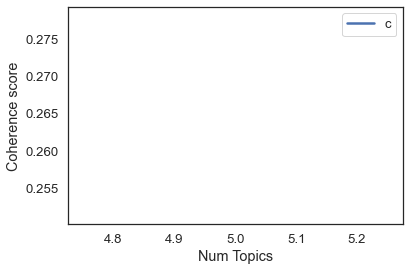

In [66]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

---

### Using Sklearn and NMF

Other approaches to clustering are possible. An example is Non-negative Matrix Factorization (or other dimensionality reduction techniques). See [here for NMF](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py). We leave some code here which goes in this direction. A full analysis and comparison is left as future work. 

In [149]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [150]:
# setup
n_samples = len(docs_ground)
n_features = 1000
n_components = 15
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [156]:
docs_ground[0][:10]

['woensdag',
 'juli',
 'jaargang',
 'abonnees',
 'limburgs',
 'dagblad',
 'directeur',
 'drs',
 'neerven',
 'uitgave']

In [152]:
def dummy(doc):
    """We use this to use the same tonekization and pre-processing we already did"""
    return doc

# Get tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer_g = TfidfVectorizer(max_features=n_features, lowercase=False, tokenizer=dummy, preprocessor=dummy)
tfidf_vectorizer_o = TfidfVectorizer(max_features=n_features, lowercase=False, tokenizer=dummy, preprocessor=dummy)
t0 = time()
tfidf_g = tfidf_vectorizer_g.fit_transform(docs_ground)
tfidf_o = tfidf_vectorizer_o.fit_transform(docs_ocr)
print("done in %0.3fs." % (time() - t0))

# Get tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer_g = CountVectorizer(max_features=n_features, lowercase=False, tokenizer=dummy, preprocessor=dummy)
tf_vectorizer_o = CountVectorizer(max_features=n_features, lowercase=False, tokenizer=dummy, preprocessor=dummy)
t0 = time()
tf_g = tf_vectorizer_g.fit_transform(docs_ground)
tf_o = tf_vectorizer_o.fit_transform(docs_ocr)
print("done in %0.3fs." % (time() - t0))
print()

Extracting tf-idf features for NMF...
done in 3.081s.
Extracting tf features for LDA...
done in 3.092s.



In [153]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

t0 = time()
nmf_g_fr = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_g)
nmf_o_fr = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_o)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model GROUND (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer_g.get_feature_names()
print_top_words(nmf_g_fr, tfidf_feature_names, n_top_words)
print("\nTopics in NMF model OCR (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer_o.get_feature_names()
print_top_words(nmf_o_fr, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=1000 and n_features=1000...
done in 1.324s.

Topics in NMF model GROUND (Frobenius norm):
Topic #0: den het zoo ten wordt onder groote welke ter ver per eenige van plaats een zullen zeer heer thans tusschen
Topic #1: het regering grote wordt tussen amerikaanse jaar ver van nederlandse onder ten minister uur een twee hij weer per mensen
Topic #2: zyn den ten schip heeren alle eenige hof des jan alhier schepen stad welke hunne zullen binnen brieven groot heden
Topic #3: heer spr den_heer uur gemeente vergadering alhier voorzitter vereeniging ned school bestuur leden heeren mej kerk voorstel spreker amsterdam lid
Topic #4: zoo gij maar hij god dat hebt zij hart leven waar zijne vrouw goed weet nooit zeide het vader heel
Topic #5: nws journaal nos serie the nieuws film programma hilversum uur sport radio muziek duitsland die amerikaanse vandaag nederland der met
Topic #6: art vereeniging leden artikel wet woorden algeme

In [154]:
# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()

nmf_g_kl = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_g)
nmf_o_kl = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_o)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model GROUND (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer_g.get_feature_names()
print_top_words(nmf_g_kl, tfidf_feature_names, n_top_words)
print("\nTopics in NMF model OCR (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer_o.get_feature_names()
print_top_words(nmf_o_kl, tfidf_feature_names, n_top_words)

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=1000 and n_features=1000...
done in 11.738s.

Topics in NMF model GROUND (generalized Kullback-Leibler divergence):
Topic #0: den het zoo wordt groote ten ver onder welke eenige tusschen regeering plaats zeer een waar werden alle thans zullen
Topic #1: het grote regering tussen amerikaanse nederlandse wordt mensen jaar ver zoals van onder twee franse enige pagina duitse hij britse
Topic #2: den zyn dito schip ten jan des schepen welke hof alle stad eenige heeren zullen ter heden binnen alhier groot
Topic #3: heer uur gemeente den_heer amsterdam alhier vereeniging rotterdam school spr vergadering ned mej voorzitter bestuur utrecht heeren jaar van leden
Topic #4: maar hij vrouw het dat goed waar heel hebt zoo weet gij vader man kwam weer zien zij leven even
Topic #5: duitsche nws duitschland journaal reuter fransche britsche frankrijk nos uur italië nieuws polen serie engeland the regeering oo

In [155]:
# fit an LDA model with the same features for comparison
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

t0 = time()
lda_g = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda_g.fit(tf_g)
lda_o = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda_o.fit(tf_o)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model GROUND:")
tf_feature_names = tf_vectorizer_g.get_feature_names()
print_top_words(lda_g, tf_feature_names, n_top_words)
print("\nTopics in LDA model OCR:")
tf_feature_names = tf_vectorizer_o.get_feature_names()
print_top_words(lda_o, tf_feature_names, n_top_words)

Fitting LDA models with tf features, n_samples=1000 and n_features=1000...
done in 19.926s.

Topics in LDA model GROUND:
Topic #0: sept den het september pag eerste wordt oostenrijk werden een ten spanje reuter oct onder waar west ver nieuwe ter
Topic #1: den het ten leden heer wordt ver minister onder van ter art plaats hof twee een werden volgens zullen maart
Topic #2: het den wordt ver ten onder minister van zullen een jaar per land nieuwe regering twee volgens alle waar weer
Topic #3: het uur van wordt den jaar een onder ver heer nieuws dag ten weer twee eerste nederland gen waar programma
Topic #4: den dito per nov pct van dec amsterdam oct jan heden londen koop schip aug mei the huis november uur
Topic #5: den het van onder ver wordt zoo ter ten heer groote staat thans onze minister per zeer hij welke zullen
Topic #6: president overleg een het onder slechts twee ver ten wordt alleen toe wanneer grote amerikaanse maanden drie werden zullen ter
Topic #7: den het van ten jaar zullen

---